# **Fine-tuning for Image Classification with 🤗 Optimum Graphcore**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on an IPU. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head and is supported by [🤗 Optimum Graphcore](https://github.com/huggingface/optimum-graphcore). The IPU config files of the supported models are available in Graphcore's [Hugging Face account](https://huggingface.co/Graphcore). You can also create your own IPU config file locally. 
Currently supported models:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

---

In this notebook, we are using both data parallelism and pipeline parallelism (see this [tutorial](https://github.com/graphcore/examples/tree/master/tutorials/tutorials/pytorch/efficient_data_loading) for more). Therefore the global batch size, which is the actual number of samples used for the weight update, is determined with three factors:
- global batch size = micro batch size * gradient accumulation steps * replication factor

and replication factor is determined by `pod_type`, which will be used as a key to select the replication factor from a dictionary defined in the IPU config file. For example, the dictionary in the IPU config file [Graphcore/roberta-base-ipu](https://huggingface.co/Graphcore/roberta-base-ipu/blob/main/ipu_config.json) looks like this:
- "replication_factor": {"pod4": 1, "pod8": 2, "pod16": 4, "pod32": 8, "pod64": 16, "default": 1}

Depending on you model and the pod machine you are using, you might need to adjust these three batch-size-related arguments.

In this notebook, we'll fine-tune from the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) checkpoint, but note that there are many more available on the [hub](https://huggingface.co/models?other=vision).


In [2]:
model_checkpoint = "facebook/dino-vitb16" # pre-trained model from which to fine-tune

ipu_config_name = "Graphcore/vit-base-ipu" # config specific to the IPU
micro_batch_size = 1 # micro batch size for training and evaluation
gradient_accumulation_steps = 32

Values for machine size and cache directories can be configured through environment variables or directly in the notebook:

In [3]:
import os

pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod4")
executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/") + "/image_classification"
dataset_dir = os.getenv("DATASETS_DIR", "./")

First of all, make sure your environment has installed the latest version of [🤗 Optimum Graphcore](https://github.com/huggingface/optimum-graphcore) and any packages we will need.


In order to improve usability and support for future users, Graphcore would like to collect information about the
applications and code being run in this notebook. The following information will be anonymised before being sent to Graphcore:

- User progression through the notebook
- Notebook details: number of cells, code being run and the output of the cells
- Environment details

You can disable logging at any time by running `%unload_ext gc_logger` from any cell.


In [4]:
%pip install -q "optimum-graphcore==0.6.1" scikit-learn torchvision==0.14.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
%pip install examples-utils[common]@git+https://github.com/graphcore/examples-utils@latest_stable
from examples_utils import notebook_logging
%load_ext gc_logger

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/graphcore/examples-utils (to revision latest_stable) to /tmp/pip-install-a926yjkj/examples-utils_a82a79d52fff4e08a47c0e0e1ece1ac6
  Running command git clone --filter=blob:none --quiet https://github.com/graphcore/examples-utils /tmp/pip-install-a926yjkj/examples-utils_a82a79d52fff4e08a47c0e0e1ece1ac6
  Running command git checkout -q 40c62e6646db8f9d60d1707a61204c95a15c7ccb
  Resolved https://github.com/graphcore/examples-utils to commit 40c62e6646db8f9d60d1707a61204c95a15c7ccb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 25.3 MB/s eta 0:00:00
IN

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [5]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [6]:

!apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument. 

In [7]:
from datasets import load_dataset 
from pathlib import Path

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option 1: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
files = list(Path(dataset_dir).rglob("EuroSAT.zip"))

dataset = load_dataset("imagefolder", data_files=str(files[0]) if files else url)

# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")

# option 3: just load any existing dataset from the hub, like CIFAR-10, FashionMNIST ...
# dataset = load_dataset("cifar10")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /tmp/huggingface_caches/datasets/imagefolder/default-5ef882a072e3a08e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-8-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [10]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [11]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

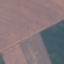

In [12]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

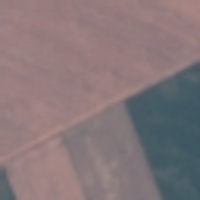

In [13]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [14]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [15]:
dataset["train"].features["label"]

ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [16]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'HerbaceousVegetation'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [17]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [18]:
import torch
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

size = (feature_extractor.size["height"], feature_extractor.size["width"])
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
            lambda tensor: tensor.half(),
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
            lambda tensor: tensor.half(),
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [19]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [20]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [21]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 7,
 'pixel_values': tensor([[[-0.3540, -0.3540, -0.3540,  ..., -0.8677, -0.8677, -0.8677],
          [-0.3540, -0.3540, -0.3540,  ..., -0.8677, -0.8677, -0.8677],
          [-0.3540, -0.3540, -0.3540,  ..., -0.8677, -0.8677, -0.8677],
          ...,
          [ 0.7417,  0.7417,  0.7417,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.7417,  0.7417,  0.7417,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.7417,  0.7417,  0.7417,  ..., -0.0116, -0.0116, -0.0116]],
 
         [[-0.3726, -0.3726, -0.3726,  ..., -0.6001, -0.6001, -0.6001],
          [-0.3726, -0.3726, -0.3726,  ..., -0.6001, -0.6001, -0.6001],
          [-0.3726, -0.3726, -0.3726,  ..., -0.6001, -0.6001, -0.6001],
          ...,
          [ 0.8179,  0.8179,  0.8179,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.0399, -0.0399, -0.0399]],


### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [22]:
from transformers import AutoModelForImageClassification
from optimum.graphcore import IPUTrainingArguments, IPUTrainer, IPUConfig

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate an `IPUTrainer`, we will need to define the training configuration and the evaluation metric. The most important is the `IPUTrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [23]:
model_name = model_checkpoint.split("/")[-1]

args = IPUTrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=micro_batch_size,
    per_device_eval_batch_size=micro_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    pod_type=pod_type,
    dataloader_drop_last=True,
    push_to_hub=False,
    # model_hub_id = f"username-or-organization/{model_name}-finetuned-eurosat"
)

/usr/local/lib/python3.8/dist-packages/optimum/graphcore/training_args.py:751: FutureWarning: `pod_type` is deprecated and will be removed in the next release of Optimum Graphcore. Use `n_ipu` instead to specify how many IPUs you would like the Trainer to use.
  warnings.warn(


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `micro_batch_size`, `gradient_accumulation_steps` and `pod_type` to determine the global batch size, which we defined at the top of the notebook, and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `IPUTrainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

We also need to define the `IPUConfig`, which is a class that specifies attributes and configuration parameters to compile and put the model on the device. We initialize it with one config name or path, which we set earlier:

In [24]:
ipu_config = IPUConfig.from_pretrained(ipu_config_name, executable_cache_dir=executable_cache_dir)

/usr/local/lib/python3.8/dist-packages/optimum/graphcore/ipu_configuration.py:383: FutureWarning: Dictionary values for `replication_factor` have been deprecated. Provide values of type `int` instead.
  check_and_set_replication_factor("replication_factor", replication_factor)
/usr/local/lib/python3.8/dist-packages/optimum/graphcore/ipu_configuration.py:384: FutureWarning: Dictionary values for `inference_replication_factor` have been deprecated. Provide values of type `int` instead.
  check_and_set_replication_factor("inference_replication_factor", inference_replication_factor)
/usr/local/lib/python3.8/dist-packages/optimum/graphcore/ipu_configuration.py:403: UserWarning: The "enable_half_first_order_momentum" parameter is deprecated
  warnings.warn('The "enable_half_first_order_momentum" parameter is deprecated')
`replicated_tensor_sharding` is not used when `replication_factor=1`


Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [25]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [26]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `IPUTrainer`:

In [27]:
trainer = IPUTrainer(
    model,
    ipu_config,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Overriding IPU config: gradient_accumulation_steps=32
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

We can check with the `evaluate` method that our `IPUTrainer` did reload the best model properly (if it was not the last one):

In [28]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Compiling Model...
Graph compilation: 100%|██████████| 100/100 [02:51<00:00]
Compiled/Loaded model in 190.77900232188404 secs
***** Running training *****
  Num examples = 24300
  Num epochs = 3
  Instantaneous batch size per device = 1
  Total training batch size (w. parallel, distributed & accumulation) = 32
  Gradient accumulation steps = 32
  Total optimization steps = 2277


  0%|          | 0/2277 [00:00<?, ?it/s]

{'loss': 3.035, 'learning_rate': 2.1929824561403507e-06, 'epoch': 0.01}
{'loss': 2.0879, 'learning_rate': 4.3859649122807014e-06, 'epoch': 0.03}
{'loss': 1.3664, 'learning_rate': 6.578947368421053e-06, 'epoch': 0.04}
{'loss': 0.88, 'learning_rate': 8.771929824561403e-06, 'epoch': 0.05}
{'loss': 0.794, 'learning_rate': 1.0964912280701754e-05, 'epoch': 0.07}
{'loss': 0.5445, 'learning_rate': 1.3157894736842106e-05, 'epoch': 0.08}
{'loss': 0.5652, 'learning_rate': 1.5350877192982457e-05, 'epoch': 0.09}
{'loss': 0.652, 'learning_rate': 1.7543859649122806e-05, 'epoch': 0.11}
{'loss': 0.6883, 'learning_rate': 1.9736842105263158e-05, 'epoch': 0.12}
{'loss': 0.3669, 'learning_rate': 2.1929824561403507e-05, 'epoch': 0.13}
{'loss': 0.3244, 'learning_rate': 2.412280701754386e-05, 'epoch': 0.14}
{'loss': 0.7826, 'learning_rate': 2.6315789473684212e-05, 'epoch': 0.16}
{'loss': 0.2575, 'learning_rate': 2.850877192982456e-05, 'epoch': 0.17}
{'loss': 0.1206, 'learning_rate': 3.0701754385964913e-05, 'e

---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Compiling Model...
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(

Graph compilation: 100%|██████████| 100/100 [00:49<00:00][A
Compiled/Loaded model in 60.59994837688282 secs
***** Running Evaluation *****
  Num examples = 2700
  Batch size = 4


  0%|          | 0/675 [00:00<?, ?it/s]

{'eval_loss': 0.10821533203125, 'eval_accuracy': 0.9625925925925926, 'eval_runtime': 8.6327, 'eval_samples_per_second': 312.764, 'eval_steps_per_second': 78.191, 'epoch': 1.0}


Saving model checkpoint to dino-vitb16-finetuned-eurosat/checkpoint-759
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in dino-vitb16-finetuned-eurosat/checkpoint-759/ipu_config.json


{'loss': 0.284, 'learning_rate': 3.7018057589067836e-05, 'epoch': 1.0}
{'loss': 0.5954, 'learning_rate': 3.677403611517814e-05, 'epoch': 1.01}
{'loss': 0.1578, 'learning_rate': 3.653001464128844e-05, 'epoch': 1.03}
{'loss': 0.1086, 'learning_rate': 3.6285993167398734e-05, 'epoch': 1.04}
{'loss': 0.3738, 'learning_rate': 3.604197169350903e-05, 'epoch': 1.05}
{'loss': 0.706, 'learning_rate': 3.579795021961933e-05, 'epoch': 1.07}
{'loss': 0.0117, 'learning_rate': 3.5553928745729625e-05, 'epoch': 1.08}
{'loss': 0.437, 'learning_rate': 3.530990727183993e-05, 'epoch': 1.09}
{'loss': 0.0256, 'learning_rate': 3.506588579795022e-05, 'epoch': 1.11}
{'loss': 0.0354, 'learning_rate': 3.482186432406052e-05, 'epoch': 1.12}
{'loss': 0.1272, 'learning_rate': 3.457784285017082e-05, 'epoch': 1.13}
{'loss': 0.1534, 'learning_rate': 3.4333821376281116e-05, 'epoch': 1.15}
{'loss': 0.141, 'learning_rate': 3.408979990239141e-05, 'epoch': 1.16}
{'loss': 0.3695, 'learning_rate': 3.384577842850171e-05, 'epoch':

***** Running Evaluation *****
  Num examples = 2700
  Batch size = 4


  0%|          | 0/675 [00:00<?, ?it/s]

{'eval_loss': 0.059600830078125, 'eval_accuracy': 0.9796296296296296, 'eval_runtime': 8.805, 'eval_samples_per_second': 306.644, 'eval_steps_per_second': 76.661, 'epoch': 2.0}


Saving model checkpoint to dino-vitb16-finetuned-eurosat/checkpoint-1518
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in dino-vitb16-finetuned-eurosat/checkpoint-1518/ipu_config.json


{'loss': 0.0095, 'learning_rate': 1.8472425573450465e-05, 'epoch': 2.0}
{'loss': 0.0113, 'learning_rate': 1.822840409956076e-05, 'epoch': 2.02}
{'loss': 0.0405, 'learning_rate': 1.798438262567106e-05, 'epoch': 2.03}
{'loss': 0.0149, 'learning_rate': 1.7740361151781356e-05, 'epoch': 2.04}
{'loss': 0.0025, 'learning_rate': 1.7496339677891656e-05, 'epoch': 2.06}
{'loss': 0.0019, 'learning_rate': 1.7252318204001953e-05, 'epoch': 2.07}
{'loss': 0.0112, 'learning_rate': 1.700829673011225e-05, 'epoch': 2.08}
{'loss': 0.0009, 'learning_rate': 1.6764275256222547e-05, 'epoch': 2.09}
{'loss': 0.0125, 'learning_rate': 1.6520253782332844e-05, 'epoch': 2.11}
{'loss': 0.1069, 'learning_rate': 1.6276232308443144e-05, 'epoch': 2.12}
{'loss': 0.0164, 'learning_rate': 1.603221083455344e-05, 'epoch': 2.13}
{'loss': 0.4969, 'learning_rate': 1.5788189360663738e-05, 'epoch': 2.15}
{'loss': 0.0009, 'learning_rate': 1.5544167886774035e-05, 'epoch': 2.16}
{'loss': 0.4128, 'learning_rate': 1.5300146412884335e-05

***** Running Evaluation *****
  Num examples = 2700
  Batch size = 4


  0%|          | 0/675 [00:00<?, ?it/s]

{'eval_loss': 0.037689208984375, 'eval_accuracy': 0.9885185185185185, 'eval_runtime': 8.7496, 'eval_samples_per_second': 308.586, 'eval_steps_per_second': 77.147, 'epoch': 3.0}


Saving model checkpoint to dino-vitb16-finetuned-eurosat/checkpoint-2277
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in dino-vitb16-finetuned-eurosat/checkpoint-2277/ipu_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from dino-vitb16-finetuned-eurosat/checkpoint-2277 (score: 0.9885185185185185).
----------

{'train_runtime': 667.8729, 'train_samples_per_second': 109.099, 'train_steps_per_second': 3.409, 'train_loss': 0.1937883012274875, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  train_loss               =     0.1938
  train_runtime            = 0:11:07.87
  train_samples_per_second =    109.099
  train_steps_per_second   =      3.409


In [29]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 2700
  Batch size = 4


  0%|          | 0/675 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9885
  eval_loss               =     0.0377
  eval_runtime            = 0:00:08.78
  eval_samples_per_second =    307.469
  eval_steps_per_second   =     76.867


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [35]:
model.push_to_hub("internetoftim/dino-vitb16-eurosat")

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/internetoftim/dino-vitb16-eurosat/commit/e91a99a3b9bd06ee90655154a9c7aa03e91c4a93', commit_message='Upload ViTForImageClassification', commit_description='', oid='e91a99a3b9bd06ee90655154a9c7aa03e91c4a93', pr_url=None, pr_revision=None, pr_num=None)

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a forest (that's not part of the EuroSAT dataset), and see how the model does.

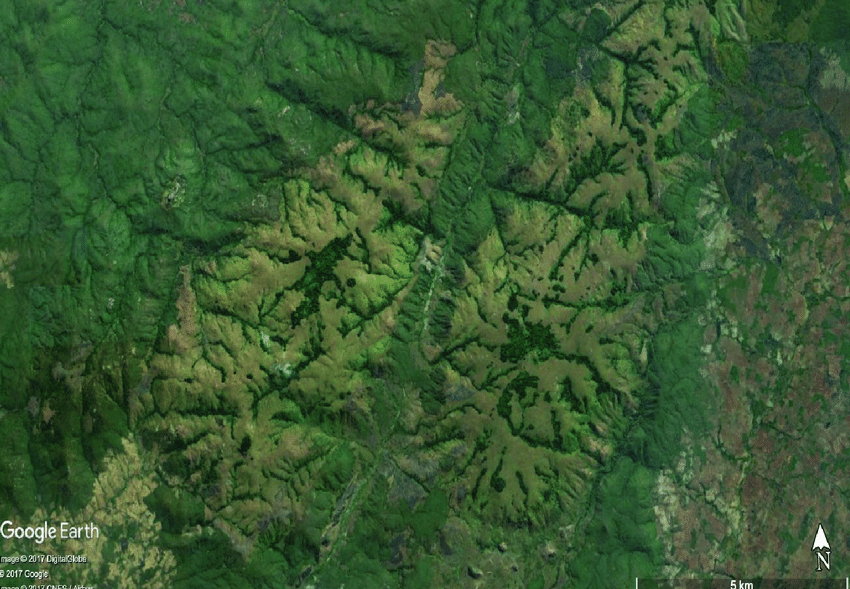

In [36]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub). Simply put your Hugging Face user or organization name into the string below to load your fine-tuned model:

In [37]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = f"internetoftim/dino-vitb16-eurosat"

try:
    # if the model was pushed to the hub it can be downloaded
    feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
    model = AutoModelForImageClassification.from_pretrained(repo_name)
except:
    # otherwise we use the local folder where the model was saved after training
    feature_extractor = AutoFeatureExtractor.from_pretrained(trainer.args.output_dir)
    model = AutoModelForImageClassification.from_pretrained(trainer.args.output_dir)

In [38]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [39]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [40]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: HerbaceousVegetation


In [42]:
trainer.detach()


AttributeError: 'IPUTrainer' object has no attribute 'detach'

Looks like our model got it correct! 